In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50, VGG16, InceptionV3, EfficientNetB0, MobileNetV3Small, MobileNetV2
from tensorflow.keras.applications.resnet50 import preprocess_input as res_pre, decode_predictions as res_decode
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_pre, decode_predictions as vgg_decode
from tensorflow.keras.applications.inception_v3 import preprocess_input as inc_pre, decode_predictions as inc_decode
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as mn_pre, decode_predictions as mn_decode
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mn2_pre, decode_predictions as mn2_decode

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import cv2

import os
import random

# Transfer to svm, random forest,... with MNIST, LeNet5
# Test on unknown models
# Mixed targeted pert.

In [2]:
model_names = ("ResNet50", "VGG", "InceptionV3", "MobileNetV3Small", "MobileNetV2")
models = (ResNet50(weights='imagenet'), VGG16(weights='imagenet'), InceptionV3(weights='imagenet'), MobileNetV3Small(weights='imagenet'), MobileNetV2(weights='imagenet'))
pre_functions = (res_pre, vgg_pre, inc_pre, mn_pre, mn2_pre)
decode_functions = (res_decode, vgg_decode, inc_decode, mn_decode, mn2_decode)

2025-05-26 16:18:32.076263: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2025-05-26 16:18:33.362560: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.
2025-05-26 16:18:33.485296: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.
2025-05-26 16:18:33.571713: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.
2025-05-26 16:18:34.849759: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.
/home/paul/anaconda3/envs/nlp/lib/python3.12/site-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 

In [3]:
def plot_histogram(data, total, label, title, target_label = None):
    if target_label != None:
        if target_label not in data.keys():
            data[target_label] = 0
        if label not in data.keys():
            data[label] = 0
        plt.bar([label, target_label, "other"], [data[label], data[target_label], total - data[label] - data[target_label]])
        print(f"Targeted evasion rate {((data[target_label]) / total) * 100: .2f}")
    else:
        plt.bar([label, "other"], [data[label], total - data[label]])
        print(f"Evasion rate {((total - data[label]) / total) * 100: .2f}")
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.title('Histogram: ' + title)
    plt.show()

labels = []

In [ ]:
def test_model(img_tensors, model, preprocess, decode, flag):
    l = {}
    target_size = (299, 299) if flag == 1 else (224, 224)

    processed_images = []
    for image in img_tensors:
        image = tf.image.resize(image, target_size)
        image = tf.cast(image, tf.float32)
        processed_images.append(image)

    batch = tf.stack(processed_images)
    batch = preprocess(batch)
    predictions = model.predict(batch)
    decoded = decode(predictions, top=1)
    
    for d in decoded:
        _, label, conf = d[0]
        # print(f"Predicted: {label} with {conf*100:.2f}% confidence")
        if label not in l.keys():
            l[label] = 1
        else:
            l[label] += 1

    return l

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step
3/4 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7fc0fa95da80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 343ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 606ms/step


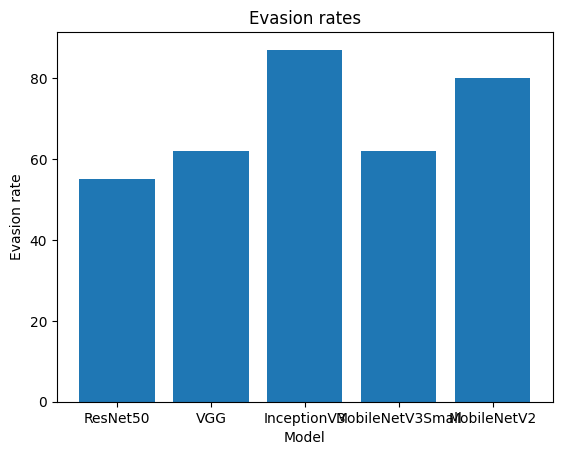

In [6]:
source_folder = "./adversarial_images/untargeted/"
image_files = [f for f in os.listdir(source_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

total = len(image_files)

image_tensors = []

for img in image_files:

    # image_path = tf.keras.utils.get_file(img, 'file://' + source_folder + img)
    image_raw = tf.io.read_file(source_folder + img)
    image = tf.image.decode_image(image_raw)
    image_tensors.append(image)

# Plot models
evasion_rates = {}
label = "banana"
for model, name, pre, dec in zip(models, model_names, pre_functions, decode_functions):
    model.trainable = False
    if name == "InceptionV3":
        labels = test_model(image_tensors, model, pre, dec, 1)
    else:
        labels = test_model(image_tensors, model, pre, dec, 0)
    if label not in labels.keys():
        evasion_rates[name] = 100
    else:
        evasion_rates[name] = ((len(image_tensors) - labels[label]) / len(image_tensors)) * 100
    
    # plot_histogram(labels, len(advs), "banana", name)

plt.bar(evasion_rates.keys(), evasion_rates.values())
plt.xlabel('Model')
plt.ylabel('Evasion rate')
plt.title('Evasion rates')
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 419ms/step


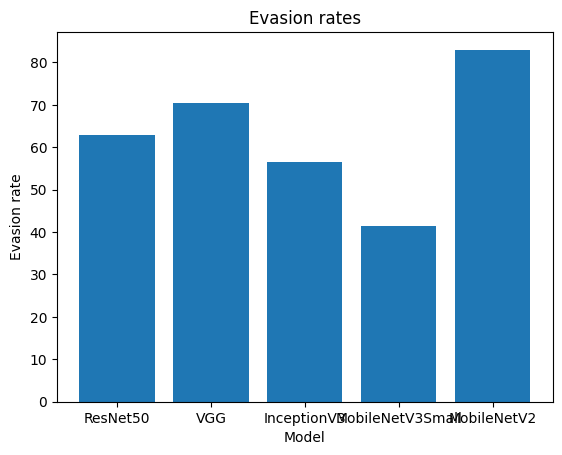

In [7]:
source_folder = "./adversarial_images/untargeted2/"
image_files = [f for f in os.listdir(source_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

total = len(image_files)

image_tensors = []

for img in image_files:

    image_path = tf.keras.utils.get_file(img, 'file://' + source_folder + img)
    image_raw = tf.io.read_file(source_folder + img)
    image = tf.image.decode_image(image_raw)
    image_tensors.append(image)

# Plot models
evasion_rates = {}
label = "banana"
for model, name, pre, dec in zip(models, model_names, pre_functions, decode_functions):
    model.trainable = False
    if name == "InceptionV3":
        labels = test_model(image_tensors, model, pre, dec, 1)
    else:
        labels = test_model(image_tensors, model, pre, dec, 0)
    if label not in labels.keys():
        evasion_rates[name] = 100
    else:
        evasion_rates[name] = ((len(image_tensors) - labels[label]) / len(image_tensors)) * 100
    
    # plot_histogram(labels, len(advs), "banana", name)

plt.bar(evasion_rates.keys(), evasion_rates.values())
plt.xlabel('Model')
plt.ylabel('Evasion rate')
plt.title('Evasion rates')
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1000ms/step
{'banana': 53, 'rapeseed': 1, 'pineapple': 4, 'lemon': 6, 'wool': 1, 'cowboy_hat': 1, 'hog': 1, 'pot': 1, 'Granny_Smith': 2, 'teddy': 2, 'rifle': 1, 'common_iguana': 1, 'Petri_dish': 1, 'cornet': 1, 'diaper': 1, 'custard_apple': 2, 'bath_towel': 1, 'sulphur_butterfly': 1, 'knot': 1, 'orange': 3, 'leafhopper': 1, 'electric_ray': 1, 'neck_brace': 1, 'pomegranate': 1, 'handkerchief': 1, 'tennis_ball': 1, 'harmonica': 1, 'jackfruit': 2, 'spaghetti_squash': 1, 'shoji': 1, 'ear': 1, 'fire_screen': 1, 'coral_fungus': 1, 'Band_Aid': 1}
Targeted evasion rate  4.00


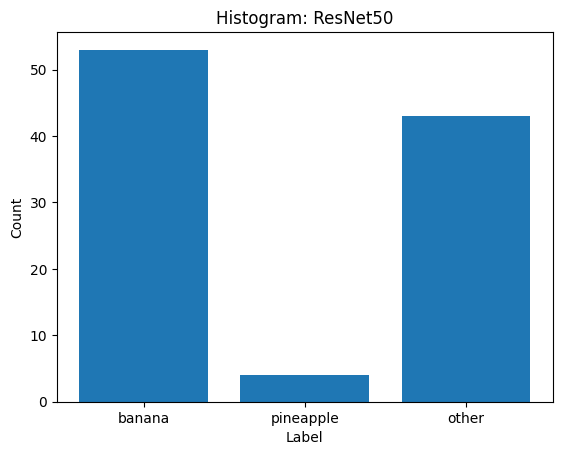

4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step
{'banana': 44, 'ladybug': 2, 'hermit_crab': 1, 'squirrel_monkey': 1, "yellow_lady's_slipper": 2, 'mask': 1, 'knot': 1, 'piggy_bank': 1, 'mousetrap': 1, 'acorn_squash': 1, 'Siamese_cat': 1, 'toucan': 1, 'Granny_Smith': 2, 'teddy': 2, 'leatherback_turtle': 1, 'African_chameleon': 1, 'pineapple': 3, 'bib': 1, 'bonnet': 2, 'vestment': 1, 'bath_towel': 2, 'lemon': 4, 'artichoke': 1, 'tennis_ball': 1, 'snorkel': 1, 'grocery_store': 2, 'leafhopper': 1, 'candle': 1, 'electric_ray': 1, 'letter_opener': 1, 'hair_slide': 2, 'spindle': 1, 'pomegranate': 1, 'soup_bowl': 1, 'television': 1, "jack-o'-lantern": 2, 'spaghetti_squash': 1, 'packet': 1, 'Italian_greyhound': 1, 'strawberry': 1, 'pencil_box': 1, 'neck_brace': 1, 'jackfruit': 1}
Targeted evasion rate  3.00


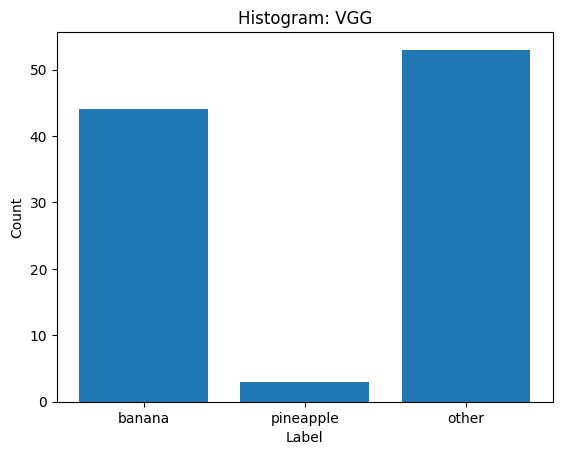

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
{'banana': 51, 'knot': 1, 'pineapple': 4, 'sandal': 2, 'pitcher': 1, 'cowboy_hat': 1, 'vase': 1, 'wool': 3, 'restaurant': 1, 'fig': 1, 'tick': 1, 'wallaby': 1, 'ear': 1, 'goldfish': 1, 'grocery_store': 3, 'French_horn': 1, 'diaper': 1, 'cucumber': 2, 'lipstick': 1, 'king_crab': 1, 'hair_slide': 2, 'carousel': 1, 'pomegranate': 1, 'mixing_bowl': 1, 'hook': 1, 'handkerchief': 1, 'mortar': 1, 'Chihuahua': 1, 'bakery': 1, 'spaghetti_squash': 1, 'turnstile': 1, 'orange': 1, 'lemon': 1, 'tailed_frog': 1, 'Italian_greyhound': 1, 'pill_bottle': 1, "jack-o'-lantern": 1, 'bee': 1, 'Band_Aid': 1, 'custard_apple': 1}
Targeted evasion rate  4.00


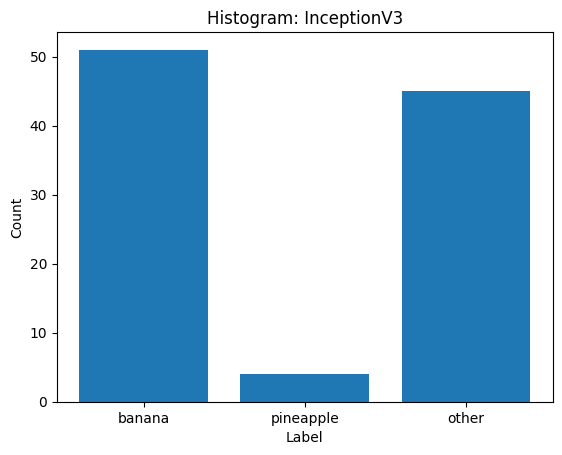

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
{'banana': 41, 'Shetland_sheepdog': 1, 'basset': 1, 'pretzel': 2, 'bath_towel': 3, 'mask': 1, 'tick': 1, 'banded_gecko': 1, 'conch': 1, 'greenhouse': 2, 'pineapple': 4, 'artichoke': 2, 'ear': 1, 'diaper': 1, 'boa_constrictor': 1, 'corn': 1, 'macaw': 1, 'mortar': 2, 'Granny_Smith': 3, 'buckeye': 1, 'tennis_ball': 2, 'sleeping_bag': 1, 'eel': 1, 'custard_apple': 2, 'lemon': 2, 'tree_frog': 1, 'zucchini': 1, 'bagel': 1, 'hair_slide': 1, 'cowboy_hat': 1, 'African_chameleon': 1, 'pomegranate': 1, 'orange': 2, 'Labrador_retriever': 1, 'ski_mask': 1, "potter's_wheel": 1, 'butternut_squash': 1, 'window_shade': 1, 'switch': 1, 'Siamese_cat': 1, 'strawberry': 1, 'horned_viper': 1, 'rapeseed': 1, 'ice_lolly': 1, 'spaghetti_squash': 1}
Targeted evasion rate  4.00


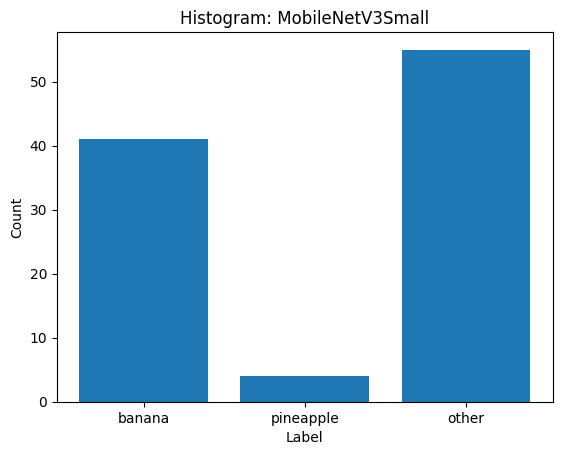

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 330ms/step
{'ear': 3, 'pineapple': 56, 'quill': 8, 'loupe': 1, 'goldfinch': 1, 'guinea_pig': 1, 'bath_towel': 2, 'banjo': 1, 'strainer': 1, 'jigsaw_puzzle': 2, "jack-o'-lantern": 2, 'spaghetti_squash': 2, 'jackfruit': 2, 'zucchini': 3, 'oxygen_mask': 1, 'tree_frog': 1, 'lemon': 1, 'tennis_ball': 1, 'drum': 1, 'clog': 1, 'African_chameleon': 1, 'croquet_ball': 1, 'Angora': 1, 'window_screen': 1, 'vase': 1, 'nipple': 1, 'lacewing': 1, 'Band_Aid': 1, 'nematode': 1}
Targeted evasion rate  56.00


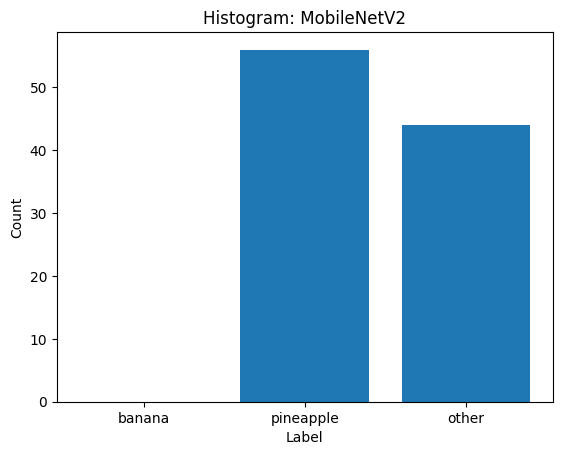

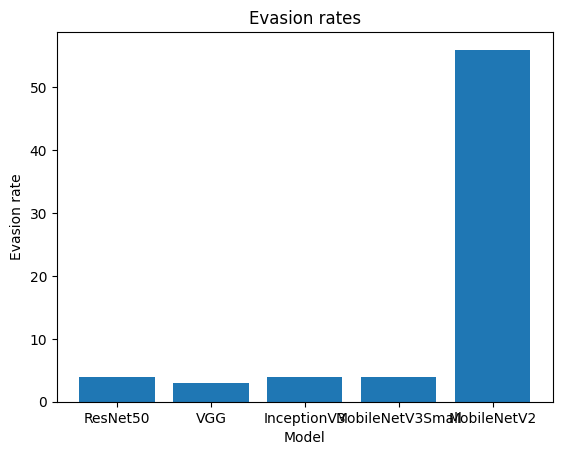

In [ ]:
source_folder = "./adversarial_images/targeted/"
image_files = [f for f in os.listdir(source_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

total = len(image_files)

image_tensors = []

for img in image_files:

    # image_path = tf.keras.utils.get_file(img, 'file://' + source_folder + img)
    image_raw = tf.io.read_file(source_folder + img)
    image = tf.image.decode_image(image_raw)
    image_tensors.append(image)

# Plot models
evasion_rates = {}
label = "banana"
target = "pineapple"
for model, name, pre, dec in zip(models, model_names, pre_functions, decode_functions):
    model.trainable = False
    if name == "InceptionV3":
        labels = test_model(image_tensors, model, pre, dec, 1)
    else:
        labels = test_model(image_tensors, model, pre, dec, 0)
    if target not in labels.keys():
        evasion_rates[name] = 0
    else:
        evasion_rates[name] = ((labels[target]) / len(image_tensors)) * 100
    # print(labels)
    plot_histogram(labels, len(image_tensors), label, name, target)

plt.bar(evasion_rates.keys(), evasion_rates.values())
plt.xlabel('Model')
plt.ylabel('Evasion rate')
plt.title('Evasion rates')
plt.show()

In [18]:
from tensorflow.keras.applications import ResNet50, VGG16, InceptionV3, EfficientNetB0, MobileNetV3Small, MobileNetV2, EfficientNetB7, Xception
from tensorflow.keras.applications import resnet50, vgg16, inception_v3, mobilenet_v2, mobilenet_v3, efficientnet, xception

from adv_img_generator import generate_untargeted_adversarial_images_multiple_models, generate_adversarial_images

#model_names = ("ResNet50", "VGG", "MobileNetV3Small")
#models = (ResNet50(weights='imagenet'), MobileNetV2(weights='imagenet'), MobileNetV3Small(weights='imagenet'), VGG16(weights='imagenet'))
#applications = (resnet50, mobilenet_v2, mobilenet_v3, vgg16)

all_models = {
    "ResNet50": (ResNet50(weights='imagenet'), resnet50.preprocess_input, resnet50.decode_predictions), 
    "MobileNetV2": (MobileNetV2(weights='imagenet'), mobilenet_v2.preprocess_input, mobilenet_v2.decode_predictions),
    "VGG16": (VGG16(weights='imagenet'), vgg16.preprocess_input, vgg16.decode_predictions),
    "InceptionV3": (InceptionV3(weights='imagenet'), inception_v3.preprocess_input, inception_v3.decode_predictions),
    }

test_models = {
    "ResNet50": (ResNet50(weights='imagenet'), resnet50.preprocess_input, resnet50.decode_predictions), 
    "VGG16": (VGG16(weights='imagenet'), vgg16.preprocess_input, vgg16.decode_predictions),
    "MobileNetV2": (MobileNetV2(weights='imagenet'), mobilenet_v2.preprocess_input, mobilenet_v2.decode_predictions),
    "MobileNetV3Small": (MobileNetV3Small(weights='imagenet'), mobilenet_v3.preprocess_input, mobilenet_v3.decode_predictions),
    "InceptionV3": (InceptionV3(weights='imagenet'), inception_v3.preprocess_input, inception_v3.decode_predictions),
    "Xception": (Xception(weights='imagenet'), xception.preprocess_input, xception.decode_predictions),
    "EfficientNetB0": (EfficientNetB0(weights='imagenet'), efficientnet.preprocess_input, efficientnet.decode_predictions),
    # "EfficientNetB7": (EfficientNetB7(weights='imagenet'), efficientnet.preprocess_input, efficientnet.decode_predictions),
}

/home/paul/anaconda3/envs/nlp/lib/python3.12/site-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


In [ ]:
epsilons = [0.00005, 0.0001, 0.001, 0.005, 0.01, 0.05]
evasion_rates_combined = {}
c = 0

full_path = "./banana_images/data/train/banana/"
target_path = "./adversarial_images/untargeted/"
image_files = [f for f in os.listdir(full_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))][:100]

sub_images = image_files
label_class = tf.Variable(954)
label = "banana"

for eps in epsilons:
    model_name = "MobileNetV2"
    model = {model_name: all_models[model_name]}

    preprocessor = model[model_name][1]
    decoder = model[model_name][2]

    advs = generate_untargeted_adversarial_images_multiple_models(sub_images, full_path, target_path, label_class, eps, model)

    total = len(advs)

    # Plot models
    evasion_rates = {}

    # for model, name, pre, dec in zip(models, model_names, pre_functions, decode_functions):
    for m in test_models.keys():
        test_m = test_models[m][0]
        test_preprocessor = test_models[m][1]
        test_decoder = test_models[m][2]

        if m == "InceptionV3" or m == "Xception":
            labels = test_model(advs, test_m, test_preprocessor, test_decoder, 1)
        else:
            labels = test_model(advs, test_m, test_preprocessor, test_decoder, 0)

        if label not in labels.keys():
            evasion_rates[m] = 100
        else:
            evasion_rates[m] = ((len(advs) - labels[label]) / len(advs)) * 100
    
        # plot_histogram(labels, len(advs), "banana", name)

    plt.bar(evasion_rates.keys(), evasion_rates.values())
    plt.xlabel('Model')
    plt.ylabel('Evasion rate')
    plt.title('Evasion rates with eps = ' + str(eps))
    plt.show()

    if c == 0:
        evasion_rates_combined = {k: [evasion_rates[k]] for k in evasion_rates.keys()}
        c += 1
    else:
        evasion_rates_combined = {k: evasion_rates_combined[k] + [evasion_rates[k]] for k in evasion_rates_combined.keys()}

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 899ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


ValueError: Input 0 of layer "efficientnetb7" is incompatible with the layer: expected shape=(None, 600, 600, 3), found shape=(10, 224, 224, 3)

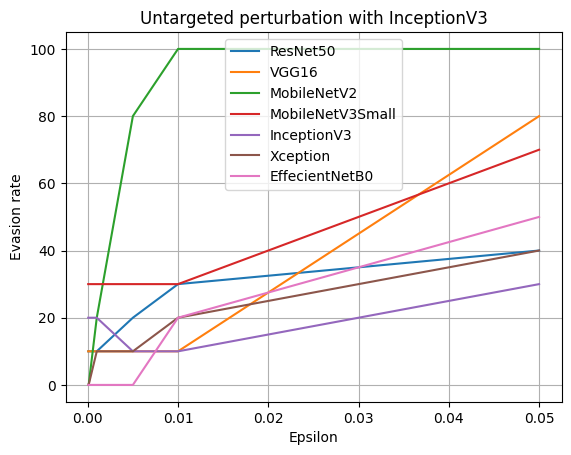

In [11]:
for label, values in evasion_rates_combined.items():
    plt.plot(epsilons, values, label=label)

plt.xlabel("Epsilon")
plt.ylabel("Evasion rate")
plt.title("Untargeted perturbation with InceptionV3")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
epsilons = [0.00005, 0.0001, 0.001, 0.005, 0.01, 0.05]
evasion_rates_combined = {}
c = 0

full_path = "./banana_images/data/train/banana/"
target_path = "./adversarial_images/untargeted2/"
image_files = [f for f in os.listdir(full_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))][:100]

sub_images = image_files
label_class = tf.Variable(954)
label = "banana"

for eps in epsilons:
    advs = generate_untargeted_adversarial_images_multiple_models(sub_images, full_path, target_path, label_class, eps, all_models)
    total = len(advs)

    # Plot models
    evasion_rates = {}

    # for model, name, pre, dec in zip(models, model_names, pre_functions, decode_functions):
    for m in all_models.keys():
        test_m = all_models[m][0]
        test_preprocessor = all_models[m][1]
        test_decoder = all_models[m][2]

        if m == "InceptionV3" or m == "Xception":
            labels = test_model(advs, test_m, test_preprocessor, test_decoder, 1)
        else:
            labels = test_model(advs, test_m, test_preprocessor, test_decoder, 0)

        if label not in labels.keys():
            evasion_rates[m] = 100
        else:
            evasion_rates[m] = ((len(advs) - labels[label]) / len(advs)) * 100
    
        # plot_histogram(labels, len(advs), "banana", name)

    # plt.bar(evasion_rates.keys(), evasion_rates.values())
    # plt.xlabel('Model')
    # plt.ylabel('Evasion rate')
    # plt.title('Evasion rates')
    # plt.show()

    if c == 0:
        evasion_rates_combined = {k: [evasion_rates[k]] for k in evasion_rates.keys()}
        c += 1
    else:
        evasion_rates_combined = {k: evasion_rates_combined[k] + [evasion_rates[k]] for k in evasion_rates_combined.keys()}

7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 385ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 384ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 390ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 396ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 394ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 392ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step


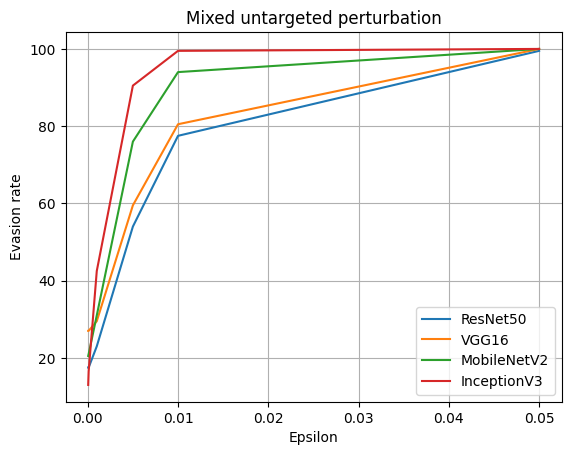

In [25]:
for label, values in evasion_rates_combined.items():
    plt.plot(epsilons, values, label=label)

plt.xlabel("Epsilon")
plt.ylabel("Evasion rate")
plt.title("Mixed untargeted perturbation")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
epsilons = [0.00005, 0.0001, 0.001, 0.005, 0.01, 0.05]
evasion_rates_combined = {}
c = 0

full_path = "./banana_images/data/train/banana/"
target_path = "./adversarial_images/targeted/"
image_files = [f for f in os.listdir(full_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))][:100]

sub_images = image_files
label_class = tf.Variable(954)
label = "banana"
target_class = tf.Variable(859)
target = "toaster"
iterations = 150

for eps in epsilons:
    model_name = "MobileNetV2"
    model = {model_name: all_models[model_name]}

    preprocessor = model[model_name][1]
    decoder = model[model_name][2]

    advs = generate_adversarial_images(sub_images, model, full_path, target_path, label_class, target_class, eps, iterations)

    total = len(advs)

    # Plot models
    evasion_rates = {}

    # for model, name, pre, dec in zip(models, model_names, pre_functions, decode_functions):
    for m in test_models.keys():
        test_m = test_models[m][0]
        test_preprocessor = test_models[m][1]
        test_decoder = test_models[m][2]

        if m == "InceptionV3" or m == "Xception":
            labels = test_model(advs, test_m, test_preprocessor, test_decoder, 1)
        else:
            labels = test_model(advs, test_m, test_preprocessor, test_decoder, 0)

        if label not in labels.keys():
            evasion_rates[m] = 100
        else:
            evasion_rates[m] = ((len(advs) - labels[label]) / len(advs)) * 100
        if target not in labels.keys():
            evasion_rates[m] = 0
        else:
            evasion_rates[m] = ((labels[target]) / len(advs)) * 100
        #plot_histogram(labels, len(image_tensors), label, name, target)
        # plot_histogram(labels, len(advs), "banana", name)

    plt.bar(evasion_rates.keys(), evasion_rates.values())
    plt.xlabel('Model')
    plt.ylabel('Evasion rate')
    plt.title('Evasion rates with eps = ' + str(eps))
    plt.show()

    if c == 0:
        evasion_rates_combined = {k: [evasion_rates[k]] for k in evasion_rates.keys()}
        c += 1
    else:
        evasion_rates_combined = {k: evasion_rates_combined[k] + [evasion_rates[k]] for k in evasion_rates_combined.keys()}

In [ ]:
for label, values in evasion_rates_combined.items():
    plt.plot(epsilons, values, label=label)

plt.xlabel("Epsilon")
plt.ylabel("Evasion rate")
plt.title("Mixed untargeted perturbation")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
epsilons = [0.00005, 0.0001, 0.001, 0.005, 0.01, 0.05]
evasion_rates_combined = {}
c = 0

full_path = "./banana_images/data/train/banana/"
target_path = "./adversarial_images/untargeted2/"
image_files = [f for f in os.listdir(full_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))][:100]

sub_images = image_files
label_class = tf.Variable(954)
label = "banana"
target_class = tf.Variable(859)
target = "toaster"
iterations = 150

for eps in epsilons:
    advs_targeted = generate_adversarial_images(sub_images, all_models, full_path, target_path, label, target_class, eps, iterations)
    # advs = generate_untargeted_adversarial_images_multiple_models(sub_images, full_path, target_path, label_class, eps, all_models)
    total = len(advs_targeted)

    # Plot models
    evasion_rates = {}

    # for model, name, pre, dec in zip(models, model_names, pre_functions, decode_functions):
    for m in test_models.keys():
        test_m = test_models[m][0]
        test_preprocessor = test_models[m][1]
        test_decoder = test_models[m][2]

        if m == "InceptionV3" or m == "Xception":
            labels = test_model(advs_targeted, test_m, test_preprocessor, test_decoder, 1)
        else:
            labels = test_model(advs_targeted, test_m, test_preprocessor, test_decoder, 0)

        if label not in labels.keys():
            evasion_rates[m] = 100
        else:
            evasion_rates[m] = ((len(advs_targeted) - labels[label]) / len(advs_targeted)) * 100
    
        # plot_histogram(labels, len(advs), "banana", name)

    # plt.bar(evasion_rates.keys(), evasion_rates.values())
    # plt.xlabel('Model')
    # plt.ylabel('Evasion rate')
    # plt.title('Evasion rates')
    # plt.show()

    if c == 0:
        evasion_rates_combined = {k: [evasion_rates[k]] for k in evasion_rates.keys()}
        c += 1
    else:
        evasion_rates_combined = {k: evasion_rates_combined[k] + [evasion_rates[k]] for k in evasion_rates_combined.keys()}

In [ ]:
for label, values in evasion_rates_combined.items():
    plt.plot(epsilons, values, label=label)

plt.xlabel("Epsilon")
plt.ylabel("Evasion rate")
plt.title("Mixed untargeted perturbation")
plt.legend()
plt.grid(True)
plt.show()

In [7]:
def normalize_for_display(tensor):
    min_val = tf.reduce_min(tensor)
    max_val = tf.reduce_max(tensor)
    return (tensor - min_val) / (max_val - min_val + 1e-8)


def get_image_perturbation(original_path, modified_path):
    # Load and decode both images
    original_raw = tf.io.read_file(original_path)
    modified_raw = tf.io.read_file(modified_path)

    original = tf.image.decode_image(original_raw, channels=3)
    modified = tf.image.decode_image(modified_raw, channels=3)

    original = tf.cast(original, tf.float32)
    modified = tf.cast(modified, tf.float32)

    # Resize if shapes differ (optional, based on use case)
    if original.shape != modified.shape:
        modified = tf.image.resize(modified, tf.shape(original)[0:2])

    # Compute the perturbation
    perturbation = modified - original
    # perturbation = normalize_for_display(perturbation)
    # perturbation = tf.reduce_mean(perturbation, axis=-1)
    # perturbation = abs(perturbation)
    # perturbation = -perturbation
    # perturbation = tf.cast(tf.clip_by_value(perturbation, 0, 255), tf.uint8)

    return perturbation

In [8]:
def deprocess_vgg(image):
    # Assume shape (H, W, 3) or (1, H, W, 3)
    if image.shape.rank == 4:
        image = image[0]
    image = image[..., ::-1]  # BGR → RGB
    image = image + [103.939, 116.779, 123.68]  # Unsubtract means
    image = tf.clip_by_value(image / 255.0, 0.0, 1.0)
    return image

def deprocess_resnet(image):
    if len(image.shape) == 4:
        image = image[0]  # remove batch dim

    # Add back the mean (ResNet expects RGB)
    image = image + [123.68, 116.779, 103.939]

    # Normalize to [0, 1]
    image = tf.clip_by_value(image / 255.0, 0.0, 1.0)

    return image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-122.09137..111.47461].


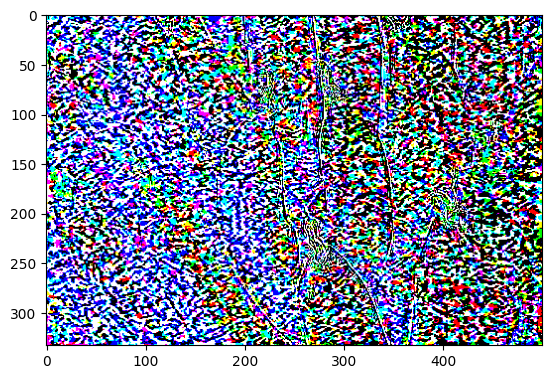

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-169.90465..173.81903].


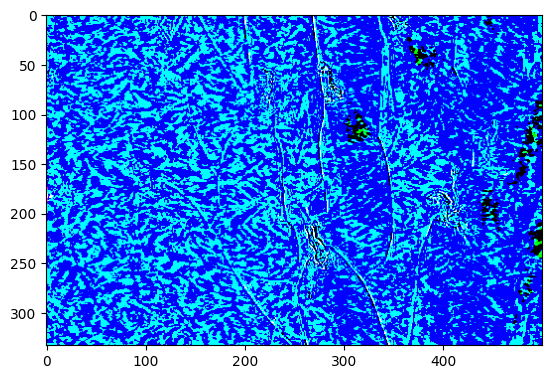

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-153.0615..162.91588].


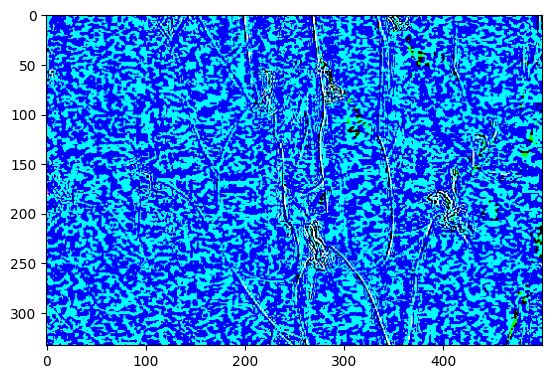

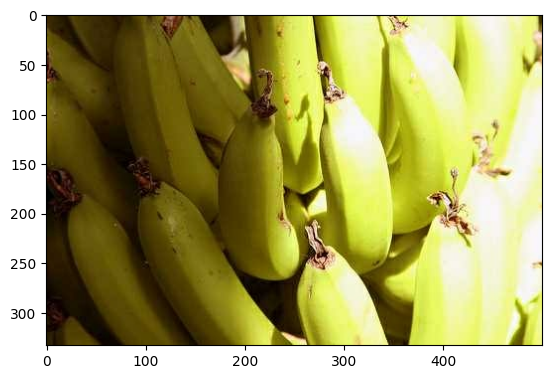

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-124.221146..127.47612].


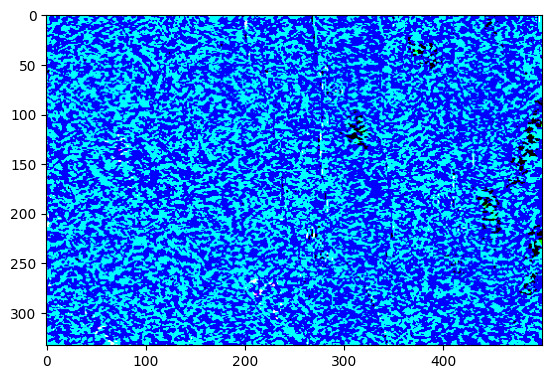

In [17]:
adv_path = "./adversarial_images/targeted2"
adv_files = [f for f in os.listdir(adv_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

random_img = random.choice(adv_files)
unt = "./adversarial_images/untargeted/" + random_img
unt2 = "./adversarial_images/untargeted2/" + random_img
adv = "./adversarial_images/targeted2/" + random_img
og = "./banana_images/data/train/banana/" + random_img

pert = get_image_perturbation(og, adv)
unt_pert = get_image_perturbation(og, unt)
unt2_pert = get_image_perturbation(og, unt2)

delta = unt2_pert - unt_pert
# pert = (get_image_perturbation(og, adv) + 255.0) / 2.0
# pert = tf.cast(tf.clip_by_value(pert, 0, 255), tf.uint8)
plt.imshow(unt_pert)
plt.show()
plt.imshow(unt2_pert)
plt.show()
plt.imshow(pert)
plt.show()

img = tf.image.decode_image(tf.io.read_file(og))
plt.imshow(img)
plt.show()

plt.imshow(delta)
plt.show()

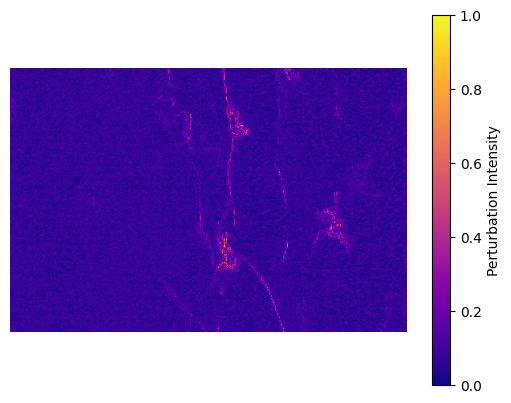

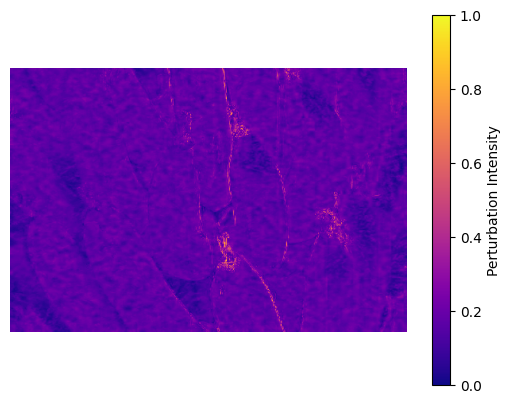

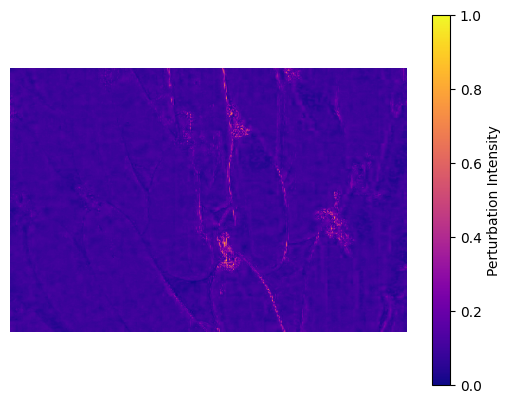

In [12]:
# pert_magnitude = tf.reduce_sum(tf.abs(pert), axis=-1)  # shape (H, W)
unt_pert_magnitude = tf.sqrt(tf.reduce_sum(tf.square(unt_pert), axis=-1))  # shape (H, W)
unt_pert_norm = (unt_pert_magnitude - tf.reduce_min(unt_pert_magnitude)) / \
            (tf.reduce_max(unt_pert_magnitude) - tf.reduce_min(unt_pert_magnitude) + 1e-8)

# unt_enhanced_pert = tf.math.log(1 + 10 * unt_pert_norm) / tf.math.log(11.0)
plt.imshow(unt_pert_norm.numpy(), cmap='plasma')
plt.colorbar(label='Perturbation Intensity')
plt.axis('off')
plt.show()

# pert_magnitude = tf.reduce_sum(tf.abs(pert), axis=-1)  # shape (H, W)
unt2_pert_magnitude = tf.sqrt(tf.reduce_sum(tf.square(unt2_pert), axis=-1))  # shape (H, W)
unt2_pert_norm = (unt2_pert_magnitude - tf.reduce_min(unt2_pert_magnitude)) / \
            (tf.reduce_max(unt2_pert_magnitude) - tf.reduce_min(unt2_pert_magnitude) + 1e-8)

# unt_enhanced_pert = tf.math.log(1 + 10 * pert_norm) / tf.math.log(11.0)
plt.imshow(unt2_pert_norm.numpy(), cmap='plasma')
plt.colorbar(label='Perturbation Intensity')
plt.axis('off')
plt.show()

# pert_magnitude = tf.reduce_sum(tf.abs(pert), axis=-1)  # shape (H, W)
pert_magnitude = tf.sqrt(tf.reduce_sum(tf.square(pert), axis=-1))  # shape (H, W)
pert_norm = (pert_magnitude - tf.reduce_min(pert_magnitude)) / \
            (tf.reduce_max(pert_magnitude) - tf.reduce_min(pert_magnitude) + 1e-8)

# enhanced_pert = tf.math.log(1 + 10 * pert_norm) / tf.math.log(11.0)
plt.imshow(pert_norm.numpy(), cmap='plasma')
plt.colorbar(label='Perturbation Intensity')
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-47.421875..40.354492].


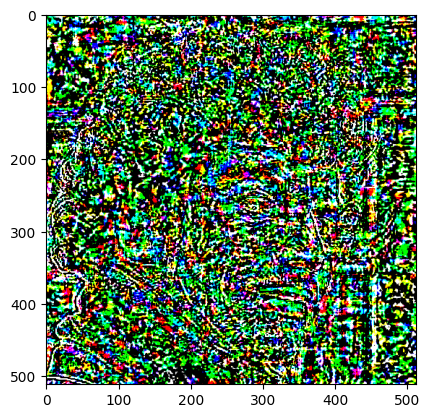

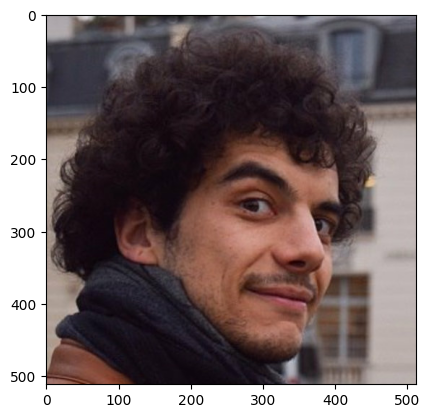

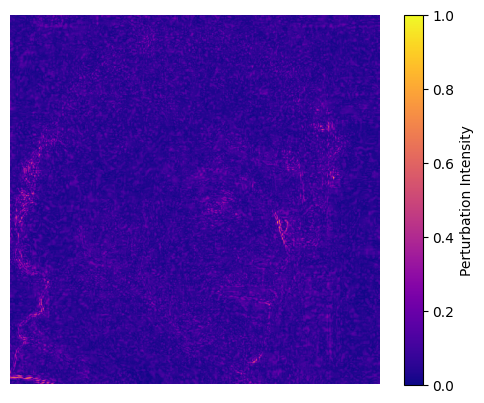

In [ ]:
adv_path = "./adversarial_images/targeted2"
adv_files = [f for f in os.listdir(adv_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

random_img = adv_files[2]

adv = "./adversarial_images/targeted2/" + random_img
og = "./adversarial_images/custom/ml.jpg"

pert = get_image_perturbation(og, adv)
plt.imshow(pert)
plt.show()

img = tf.image.decode_image(tf.io.read_file(og))
plt.imshow(img)
plt.show()

pert_magnitude = tf.sqrt(tf.reduce_sum(tf.square(pert), axis=-1))  # shape (H, W)
pert_norm = (pert_magnitude - tf.reduce_min(pert_magnitude)) / \
            (tf.reduce_max(pert_magnitude) - tf.reduce_min(pert_magnitude) + 1e-8)

# enhanced_pert = tf.math.log(1 + 10 * pert_norm) / tf.math.log(11.0)
plt.imshow(pert_norm.numpy(), cmap='plasma')
plt.colorbar(label='Perturbation Intensity')
plt.axis('off')
plt.show()

In [15]:
def build_small_model(input_shape=(64, 64, 3), num_classes=10):
    model = models.Sequential([
        layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [16]:
# Create dummy dataset
x_train = tf.random.uniform((100, 64, 64, 3), minval=0, maxval=1)
y_train = tf.random.uniform((100,), minval=0, maxval=10, dtype=tf.int32)

model = build_small_model()
model.fit(x_train, y_train, epochs=5, batch_size=16)

AttributeError: 'tuple' object has no attribute 'Sequential'